# Analysis of HAN OOPD results


In [1]:
# Imports
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from scipy.stats import pearsonr
import pingouin as pg

from lib.analysis_tools import plot_boxes_grade_cats

In [2]:
# Load ABT, cleanup and concatenate
abt = pd.read_csv('data/han_oopd_abt.csv')
abt

,assignment,file,kloc,submission_date,grade,subgrade_classes,subgrade_inheritance,subgrade_polymorphism,subgrade_code_quality,errors_total,...,checkstyle_NestedIfDepth,checkstyle_NestedTryDepth,checkstyle_ParameterAssignment,checkstyle_ParameterNumber,checkstyle_ReturnCount,checkstyle_SimplifyBooleanExpression,checkstyle_SimplifyBooleanReturn,checkstyle_UnusedLocalVariable,checkstyle_VariableDeclarationUsageDistance,checkstyle_VisibilityModifier
0,HAN OOPD,aGFzaC03NDgxMzA1NzQ5Nzk3Njc0NDcy,2.188,2018-04-05,9.0,9.5,9.5,9.5,9.0,316.270567,...,0.457038,0.0,0.914077,0.457038,0.000000,0.000000,0.0,0.000000,0.457038,0.914077
1,HAN OOPD,aGFzaDM2MDMxMzc0MjQ5MzYzODMxMjc=,0.570,2018-04-05,7.0,7.0,7.0,5.5,7.0,401.754386,...,5.263158,0.0,0.000000,0.000000,1.754386,1.754386,0.0,0.000000,0.000000,5.263158
2,HAN OOPD,aGFzaC0xMjI0OTA2MDA2MTI0MzY0MDY=,1.230,2020-04-06,6.7,6.0,6.0,6.0,6.0,252.032520,...,1.626016,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.626016,17.886179
3,HAN OOPD,aGFzaC02ODQzMDY0MTQyMTE3MzA1NDc0,1.522,2021-04-01,8.9,10.0,8.0,8.0,10.0,270.696452,...,1.314060,0.0,0.000000,0.657030,0.000000,0.000000,0.0,0.000000,0.000000,22.996058
4,HAN OOPD,aGFzaDUwNDMzMzAyOTQxNDQzNzY5ODc=,1.325,2022-04-07,8.7,8.0,8.0,6.0,10.0,272.452830,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,9.811321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,HAN OOPD,aGFzaC0xMzgwOTE0OTQ2MDQyNDMyMDYx,2.677,2022-04-07,8.5,8.0,8.0,6.0,8.0,688.830781,...,2.614867,0.0,0.000000,1.120657,0.000000,0.000000,0.0,0.373552,0.000000,2.614867
525,HAN OOPD,aGFzaDg2Mjc1NDEwMzU0MTk3NDQ1MzQ=,2.123,2022-03-30,7.1,6.0,6.0,6.0,6.0,439.001413,...,0.471032,0.0,0.000000,1.413095,0.942063,0.000000,0.0,0.000000,0.000000,25.435704
526,HAN OOPD,aGFzaC0yNjYwNTU5NDUyMjIyMDk4MjM0,1.893,2022-05-13,6.4,6.0,6.0,6.0,6.0,659.270998,...,0.000000,0.0,0.000000,0.000000,0.000000,1.056524,0.0,0.000000,9.508716,12.678288
527,HAN OOPD,aGFzaDg2MzQ0MzUxMTE1Mzc4NDg2MTA=,1.042,2022-05-12,8.4,8.0,8.0,6.0,8.0,194.817658,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


# Cleanup

In [3]:
print(f"Number of assignments total: {abt['grade'].count()} ")
print(f"Number of assignments with a grade of zero: {abt[abt['grade'] < 1]['grade'].count()}")
print(f"Number of assignments where no errors could be detected: {abt[abt['errors_total'] == 0]['grade'].count()}")

abt_clean = abt[(abt['grade'] >= 1) & (abt['errors_total'] > 0)].reset_index(drop = True).copy()

print(f"Number of assignments after cleanup: {abt_clean['grade'].count()}")


Number of assignments total: 529 
Number of assignments with a grade of zero: 11
Number of assignments where no errors could be detected: 37
Number of assignments after cleanup: 483


In [4]:
# Process subgrades. Calculate a final grade based on these subgrades only.
# This grade is the part of the grade that is related to code quality only.
[x for x in abt_clean.columns if x.startswith('subgrade_')]
def calculate_grade_cs(row):
    sg_weights = {
        'subgrade_classes' : 0.1,
        'subgrade_inheritance' : 0.1,
        'subgrade_polymorphism' : 0.1,
        'subgrade_code_quality' : 0.1,
    }
    grade_cq = 0
    sum_weights = 0
    for sg, weight in sg_weights.items():
        grade_cq += row[sg] * weight
        sum_weights += weight
    # Scale to full grade
    return grade_cq / sum_weights

abt_clean['grade_cq'] = abt_clean.apply(calculate_grade_cs, axis = 1)

In [5]:

# Drop columns for subgrades
abt_clean = abt_clean.drop([x for x in abt_clean.columns if x.startswith('subgrade')],axis = 1)

# NaNs are metrics that were not found for a specific assignment. Just set them to 0
abt_clean = abt_clean.fillna(0)

# Failing grades are distributed unevenly because they contain knockout values.
# Set all of them to 5.0 if they're lower than 5.0
abt_clean.grade = abt_clean['grade'].map(lambda x : 5.0 if x < 5.0 else x)
abt_clean.grade_cq = abt_clean['grade_cq'].map(lambda x : 5.0 if x < 5.0 else x)


In [6]:

# Only retain columns for categories, clusters and totals.
abt_final = abt_clean[['grade', 'grade_cq',
                       'errors_count',
                       'errors_total'] + [x for x in abt_clean.columns if x.startswith('cluster_') ] +
                       ['pmd_count',
                       'pmd_total'] + [x for x in abt_clean.columns if x.startswith('pmd_cat_')] +
                       ['checkstyle_count',
                        'checkstyle_total'] + [x for x in abt_clean.columns if x.startswith('checkstyle_cat_')]].reset_index(drop = True).copy()

# Additionally, create columns for the categories teachers were
# questioned about.
abt_final['cat_Code style'] = abt_final['pmd_cat_Code style'].copy()
abt_final['cat_Design'] = abt_final['pmd_cat_Design'] + abt_final['checkstyle_cat_Class Design']
abt_final['cat_ErrorProne'] = abt_final['pmd_cat_ErrorProne'].copy()
abt_final['cat_SizeViolations'] = abt_final['checkstyle_cat_SizeViolations'].copy()



In [7]:
# When graphing box plots, normalize values between 0 and 1
must_normalize = False

if must_normalize:
    for x in abt_final.columns:
        if x == 'grade':
          continue
        abt_final[x] = abt_final[x] / abt_final[x].max()
abt_final

,grade,grade_cq,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,...,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
0,9.0,9.375,18.738574,316.270567,149.908592,2.742230,21.023766,141.224863,1.371115,13.254113,...,0.0,6.855576,132.084095,0.000000,1.828154,0.457038,132.084095,26.965265,12.797075,0.457038
1,7.0,6.625,45.614035,401.754386,114.035088,5.263158,92.982456,189.473684,0.000000,28.070175,...,0.0,49.122807,177.192982,0.000000,1.754386,0.000000,128.070175,87.719298,1.754386,0.000000
2,6.7,6.000,24.390244,252.032520,125.203252,0.813008,56.910569,67.479675,1.626016,17.073171,...,0.0,17.886179,73.983740,0.000000,0.813008,0.000000,110.569106,56.910569,3.252033,0.000000
3,8.9,9.000,22.339028,270.696452,96.583443,5.256242,40.078844,128.777924,0.000000,14.454665,...,0.0,46.649146,64.388962,0.000000,1.971091,0.657030,86.070959,105.781866,1.314060,0.657030
4,8.7,8.000,27.924528,272.452830,110.943396,0.754717,66.415094,94.339623,0.000000,18.867925,...,0.0,32.452830,70.943396,1.509434,0.754717,0.000000,100.377358,86.037736,3.773585,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,8.5,7.500,16.062757,688.830781,116.174823,2.614867,31.004856,537.915577,1.120657,10.459470,...,0.0,38.849458,500.560329,0.747105,1.120657,1.120657,107.583115,64.251027,2.988420,1.120657
479,7.1,6.000,21.667452,439.001413,86.669807,8.007537,68.770608,275.082431,0.471032,12.717852,...,0.0,56.994819,236.457843,7.065473,4.239284,2.826189,74.422986,106.453132,0.471032,2.826189
480,6.4,6.000,23.243529,659.270998,156.893819,8.452192,62.863180,431.061807,0.000000,13.734812,...,0.0,55.995774,397.253038,8.452192,4.226096,1.056524,151.611199,87.163233,1.056524,1.056524
481,8.4,7.500,16.314779,194.817658,75.815739,0.000000,54.702495,64.299424,0.000000,10.556622,...,0.0,17.274472,64.299424,0.000000,0.000000,0.000000,75.815739,50.863724,2.879079,0.000000


# Distribution of grades

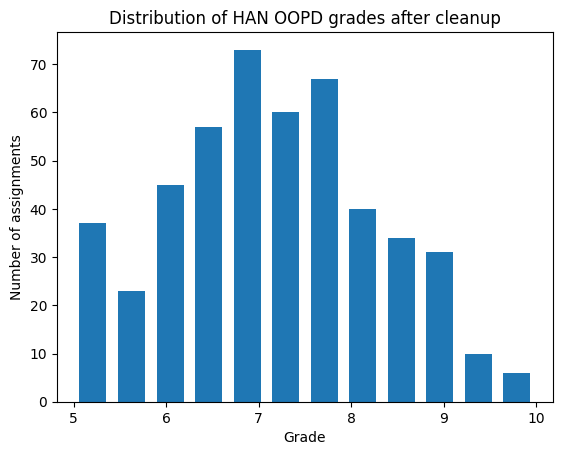

In [8]:
ax = abt_final['grade'].hist(bins=12, rwidth = 0.7)
ax.grid(False)
ax.set_xlabel('Grade')
ax.set_ylabel('Number of assignments')
ax.set_title('Distribution of HAN OOPD grades after cleanup')
plt.show()

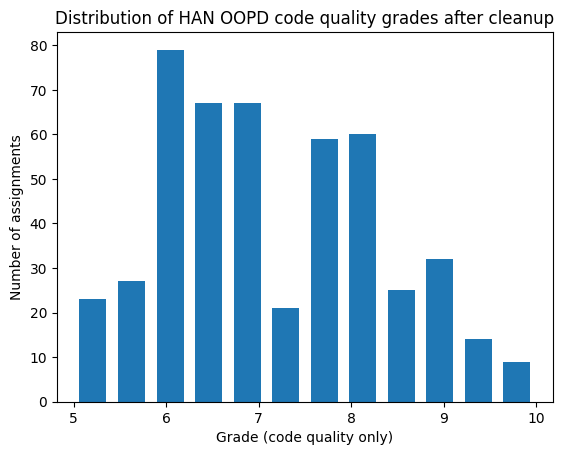

In [9]:
ax = abt_final['grade_cq'].hist(bins=12, rwidth = 0.7)
ax.grid(False)
ax.set_xlabel('Grade (code quality only)')
ax.set_ylabel('Number of assignments')
ax.set_title('Distribution of HAN OOPD code quality grades after cleanup')
plt.show()

## Distribution of failing grades before cleanup

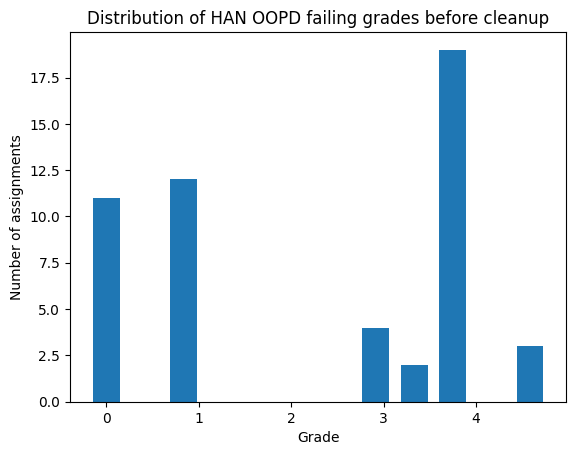

In [10]:
ax = abt[abt['grade'] < 5.5]['grade'].hist(
    bins = 12, 
    rwidth = 0.7, 
    align="left")
ax.grid(False)
ax.set_xlabel('Grade')
ax.set_ylabel('Number of assignments')
ax.set_title('Distribution of HAN OOPD failing grades before cleanup')
plt.show()

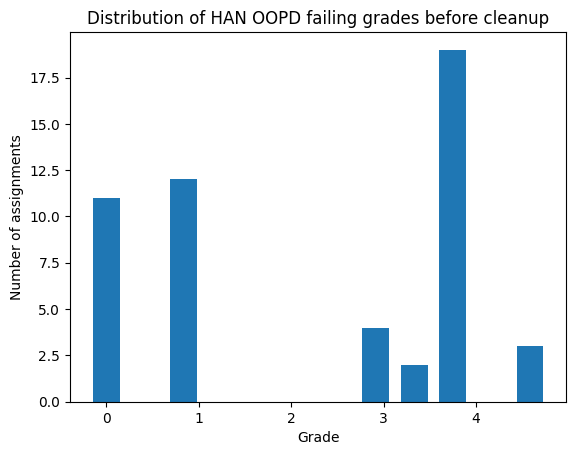

In [11]:
ax = abt[abt['grade'] < 5.5]['grade'].hist(
    bins = 12, 
    rwidth = 0.7, 
    align="left")
ax.grid(False)
ax.set_xlabel('Grade')
ax.set_ylabel('Number of assignments')
ax.set_title('Distribution of HAN OOPD failing grades before cleanup')
plt.show()

# Correlations

## Correlations for all grades

In [12]:
corr = abt_final.corr(method='spearman') # Spearman to correct for non-normal distribution. Effect is very small, however.
corr.style.background_gradient(cmap='coolwarm')

,grade,grade_cq,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,pmd_total,pmd_cat_Best practices,pmd_cat_Code style,pmd_cat_Design,pmd_cat_ErrorProne,checkstyle_count,checkstyle_total,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
grade,1.000000,0.921923,-0.422954,-0.187950,-0.058162,-0.050189,-0.340522,-0.129140,0.115627,-0.415239,-0.139291,-0.149643,-0.128515,0.014205,0.035290,-0.365145,-0.189496,0.094879,-0.222101,-0.150294,0.008268,-0.057987,0.137430,-0.128515,-0.171855,0.035290,0.137430
grade_cq,0.921923,1.000000,-0.359939,-0.161471,-0.003513,-0.013701,-0.283330,-0.126002,0.092996,-0.351815,-0.071946,-0.107388,-0.064568,0.044259,0.044398,-0.316247,-0.184137,0.094230,-0.181962,-0.154141,0.000739,-0.016844,0.142615,-0.064568,-0.123267,0.044398,0.142615
errors_count,-0.422954,-0.359939,1.000000,0.343672,0.314654,0.208960,0.415883,0.240629,-0.123977,0.961757,0.396461,0.355727,0.297733,0.236526,0.070652,0.920242,0.279225,-0.037972,0.333646,0.221321,-0.149497,0.227931,-0.094394,0.297733,0.378704,0.070652,-0.094394
errors_total,-0.187950,-0.161471,0.343672,1.000000,0.650378,0.373984,0.477880,0.902998,0.052578,0.292177,0.720837,0.355259,0.630236,0.393901,0.068998,0.372919,0.921536,-0.035144,0.679186,0.829988,0.129766,0.377399,0.317545,0.630236,0.724026,0.068998,0.317545
cluster_Best practices,-0.058162,-0.003513,0.314654,0.650378,1.000000,0.210270,0.306859,0.397064,0.106181,0.273948,0.811765,0.377098,0.879178,0.201080,0.179345,0.327473,0.448602,0.005044,0.485357,0.356901,0.161339,0.231091,0.168957,0.879178,0.465112,0.179345,0.168957
cluster_Complexity,-0.050189,-0.013701,0.208960,0.373984,0.210270,1.000000,-0.034713,0.386855,-0.057206,0.173032,0.255549,0.229996,0.064748,0.388090,0.030946,0.241062,0.352110,0.042899,0.061607,0.377588,-0.072001,0.925353,0.414455,0.064748,0.246655,0.030946,0.414455
cluster_Incomplete code,-0.340522,-0.283330,0.415883,0.477880,0.306859,-0.034713,1.000000,0.254863,-0.008928,0.428132,0.608707,0.410810,0.473150,0.404994,-0.002579,0.330121,0.339512,-0.036195,0.476111,0.267945,-0.040105,0.006270,-0.051015,0.473150,0.577074,-0.002579,-0.051015
cluster_Reusability and extendibility,-0.129140,-0.126002,0.240629,0.902998,0.397064,0.386855,0.254863,1.000000,0.028212,0.179718,0.459348,0.215416,0.376879,0.312288,0.026410,0.301006,0.960344,-0.034005,0.638855,0.898133,0.093269,0.372580,0.330234,0.376879,0.645432,0.026410,0.330234
cluster_Side effects,0.115627,0.092996,-0.123977,0.052578,0.106181,-0.057206,-0.008928,0.028212,1.000000,-0.087464,0.109723,0.232812,0.068893,0.086662,0.077066,-0.164050,0.002633,0.092962,0.041787,-0.036932,0.075662,-0.044231,0.148922,0.068893,0.080414,0.077066,0.148922
pmd_count,-0.415239,-0.351815,0.961757,0.292177,0.273948,0.173032,0.428132,0.179718,-0.087464,1.000000,0.392343,0.415565,0.260723,0.267695,0.104283,0.787319,0.207586,-0.045528,0.293607,0.155217,-0.234009,0.170669,-0.131045,0.260723,0.373582,0.104283,-0.131045


In [13]:
pearson_vals = []
pd.reset_option('display.float_format')
# pd.options.display.float_format = '{:,.4f}'.format
for cat in abt_final.columns.to_numpy():
    if cat == 'grade' or cat == 'grade_cq':
        continue
    result = pearsonr(abt_final['grade'], abt_final[cat])
    confidence_interval = result.confidence_interval(confidence_level = 0.99)
    pearson_vals.append({
        'Measure' : cat,
        'Average value': round(abt_final[cat].mean()),
        'SD' : float(round(abt_final[cat].std() * 100)) / 100,
        'Correlation coefficient' : float(round(result.statistic * 100)) / 100,
        'P-value' : result.pvalue,
        'P-value disp' : float(int(result.pvalue * 100000)) / 100000,
        'Confidence interval .99 low' : confidence_interval[0],
        'Confidence interval .99 high' : confidence_interval[1],
    })
pd.DataFrame(pearson_vals).to_excel('data/han_oopd_pearson_vals.xlsx')
print("Pearson values for final grade (all grades)")
pd.DataFrame(pearson_vals)

Pearson values for final grade (all grades)


,Measure,Average value,SD,Correlation coefficient,P-value,P-value disp,Confidence interval .99 low,Confidence interval .99 high
0,errors_count,31,10.85,-0.41,4.976047e-21,0.00000,-0.503106,-0.307983
1,errors_total,384,155.44,-0.11,1.640435e-02,0.01640,-0.223329,0.007982
2,cluster_Best practices,135,35.93,-0.03,5.834121e-01,0.58341,-0.141631,0.092287
3,cluster_Complexity,6,5.39,-0.06,2.078328e-01,0.20783,-0.173280,0.060022
4,cluster_Incomplete code,64,27.99,-0.33,5.063008e-14,0.00000,-0.433734,-0.225408
5,cluster_Reusability and extendibility,178,135.59,-0.05,2.940409e-01,0.29404,-0.163955,0.069579
6,cluster_Side effects,1,1.74,0.04,3.833356e-01,0.38333,-0.077638,0.156059
7,pmd_count,19,7.03,-0.41,1.416926e-20,0.00000,-0.499153,-0.303198
8,pmd_total,185,46.17,-0.11,1.667454e-02,0.01667,-0.223069,0.008256
9,pmd_cat_Best practices,13,8.74,-0.15,8.214150e-04,0.00082,-0.264077,-0.035331


In [14]:
# Do the same, but only for the code quality component of the grade.
pearson_vals = []
pd.reset_option('display.float_format')
# pd.options.display.float_format = '{:,.4f}'.format
for cat in abt_final.columns.to_numpy():
    if cat == 'grade' or cat == 'grade_cq':
        continue
    result = pearsonr(abt_final['grade_cq'], abt_final[cat])
    confidence_interval = result.confidence_interval(confidence_level = 0.99)
    pearson_vals.append({
        'Measure' : cat,
        'Average value': float(round(abt_final[cat].mean() * 100)) / 100,
        'SD' : float(round(abt_final[cat].std() * 100)) / 100,
        'Correlation coefficient' : float(round(result.statistic * 100)) / 100,
        'P-value' : result.pvalue,
        'P-value disp' : float(int(result.pvalue * 100000)) / 100000,
        'Confidence interval .99 low' : confidence_interval[0],
        'Confidence interval .99 high' : confidence_interval[1],
    })
pd.DataFrame(pearson_vals).to_excel('data/han_oopd_cq_pearson_vals.xlsx')
print("Pearson values for code quality grade (all grades)")
pd.DataFrame(pearson_vals)

Pearson values for code quality grade (all grades)


,Measure,Average value,SD,Correlation coefficient,P-value,P-value disp,Confidence interval .99 low,Confidence interval .99 high
0,errors_count,30.72,10.85,-0.37,8.360829e-17,0.00000,-0.463674,-0.260683
1,errors_total,384.01,155.44,-0.10,2.604211e-02,0.02604,-0.215744,0.015951
2,cluster_Best practices,135.14,35.93,0.03,5.077895e-01,0.50778,-0.087133,0.146719
3,cluster_Complexity,6.13,5.39,-0.02,5.893026e-01,0.58930,-0.141248,0.092674
4,cluster_Incomplete code,63.90,27.99,-0.28,2.630101e-10,0.00000,-0.386644,-0.171011
5,cluster_Reusability and extendibility,178.08,135.59,-0.07,1.521485e-01,0.15214,-0.180907,0.052173
6,cluster_Side effects,0.76,1.74,0.03,4.488227e-01,0.44882,-0.082825,0.150962
7,pmd_count,19.32,7.03,-0.36,1.502310e-16,0.00000,-0.461084,-0.257611
8,pmd_total,184.54,46.17,-0.04,3.759998e-01,0.37599,-0.156661,0.077025
9,pmd_cat_Best practices,12.78,8.74,-0.10,2.173474e-02,0.02173,-0.218768,0.012778


## Correlations for passing grades only

In [15]:
corr = abt_final[abt_final['grade'] >= 5.5].corr()
corr.style.background_gradient(cmap='coolwarm')

,grade,grade_cq,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,pmd_total,pmd_cat_Best practices,pmd_cat_Code style,pmd_cat_Design,pmd_cat_ErrorProne,checkstyle_count,checkstyle_total,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
grade,1.000000,0.920977,-0.411881,-0.124032,-0.039126,-0.053308,-0.339982,-0.064012,-0.000179,-0.411551,-0.127611,-0.166359,-0.088915,-0.061120,-0.030566,-0.360664,-0.099067,0.099564,-0.244106,-0.058944,-0.019559,-0.060836,0.081217,-0.088915,-0.205490,-0.030566,0.081217
grade_cq,0.920977,1.000000,-0.352832,-0.114006,0.020796,-0.016662,-0.285630,-0.080142,0.006707,-0.348965,-0.050466,-0.113061,-0.025308,-0.019419,-0.016835,-0.314771,-0.113239,0.112524,-0.176654,-0.087373,-0.024439,-0.024282,0.095577,-0.025308,-0.134037,-0.016835,0.095577
errors_count,-0.411881,-0.352832,1.000000,0.220351,0.309351,0.248089,0.378584,0.088212,0.011629,0.970920,0.389304,0.336190,0.241117,0.270614,0.216983,0.921521,0.122036,-0.020783,0.344952,0.064172,-0.096566,0.279487,0.000807,0.241117,0.399326,0.216983,0.000807
errors_total,-0.124032,-0.114006,0.220351,1.000000,0.491616,0.442692,0.246257,0.947103,0.018666,0.188131,0.541966,0.257680,0.414796,0.380917,0.138097,0.244927,0.960315,-0.004663,0.475181,0.921959,0.089292,0.404193,0.326245,0.414796,0.554894,0.138097,0.326245
cluster_Best practices,-0.039126,0.020796,0.309351,0.491616,1.000000,0.258785,0.280216,0.234777,0.041323,0.268433,0.833241,0.340070,0.883149,0.206448,0.231475,0.336855,0.283992,0.028600,0.410710,0.211337,0.187303,0.276768,0.274621,0.883149,0.407005,0.231475,0.274621
cluster_Complexity,-0.053308,-0.016662,0.248089,0.442692,0.258785,1.000000,-0.011418,0.401786,-0.034959,0.204760,0.300368,0.211048,0.104818,0.367239,0.141205,0.287198,0.405063,-0.037572,0.088374,0.398283,-0.044857,0.911938,0.406595,0.104818,0.278457,0.141205,0.406595
cluster_Incomplete code,-0.339982,-0.285630,0.378584,0.246257,0.280216,-0.011418,1.000000,0.015881,0.031942,0.398351,0.588562,0.447933,0.435202,0.411171,0.001449,0.298952,0.085443,0.040127,0.456632,0.001473,0.070209,0.028001,0.045963,0.435202,0.559915,0.001449,0.045963
cluster_Reusability and extendibility,-0.064012,-0.080142,0.088212,0.947103,0.234777,0.401786,0.015881,1.000000,-0.007197,0.059856,0.274711,0.108203,0.153907,0.287466,0.090961,0.123124,0.988701,-0.019709,0.342252,0.980564,0.040698,0.348544,0.275194,0.153907,0.407417,0.090961,0.275194
cluster_Side effects,-0.000179,0.006707,0.011629,0.018666,0.041323,-0.034959,0.031942,-0.007197,1.000000,0.026056,0.077007,0.216624,0.041804,0.007479,0.021930,-0.013233,-0.004274,0.050119,0.088171,-0.022713,0.025229,-0.001556,0.052544,0.041804,0.065591,0.021930,0.052544
pmd_count,-0.411551,-0.348965,0.970920,0.188131,0.268433,0.204760,0.398351,0.059856,0.026056,1.000000,0.389332,0.381171,0.214088,0.298166,0.209113,0.801757,0.085291,-0.016871,0.315486,0.033199,-0.136452,0.227439,-0.031574,0.214088,0.395175,0.209113,-0.031574


In [16]:
pearson_vals = []
for cat in abt_final.columns.to_numpy():
    if cat == 'grade':
        continue
    result = pearsonr(abt_final[abt_final['grade'] >= 5.5]['grade'], abt_final[abt_final['grade'] >= 5.5][cat])
    confidence_interval = result.confidence_interval(confidence_level = 0.95)
    pearson_vals.append({
        'Metric' : cat,
        'Coefficient' : result.statistic,
        'P-value' : result.pvalue,
        'P-value disp' : float(int(result.pvalue * 100000)) / 100000,
        'Confidence interval .95 low' : confidence_interval[0],
        'Confidence interval .95 high' : confidence_interval[1],
    })
pd.DataFrame(pearson_vals)

,Metric,Coefficient,P-value,P-value disp,Confidence interval .95 low,Confidence interval .95 high
0,grade_cq,0.920977,7.191065e-184,0.00000,0.905564,0.933962
1,errors_count,-0.411881,1.083995e-19,0.00000,-0.486142,-0.331715
2,errors_total,-0.124032,8.736933e-03,0.00873,-0.214415,-0.031543
3,cluster_Best practices,-0.039126,4.097814e-01,0.40978,-0.131500,0.053923
4,cluster_Complexity,-0.053308,2.612523e-01,0.26125,-0.145441,0.039741
5,cluster_Incomplete code,-0.339982,1.572984e-13,0.00000,-0.419589,-0.255186
6,cluster_Reusability and extendibility,-0.064012,1.771971e-01,0.17719,-0.155937,0.029013
7,cluster_Side effects,-0.000179,9.969849e-01,0.99698,-0.093030,0.092675
8,pmd_count,-0.411551,1.166531e-19,0.00000,-0.485838,-0.331361
9,pmd_total,-0.127611,6.966283e-03,0.00696,-0.217882,-0.035175


# Distribution of errors

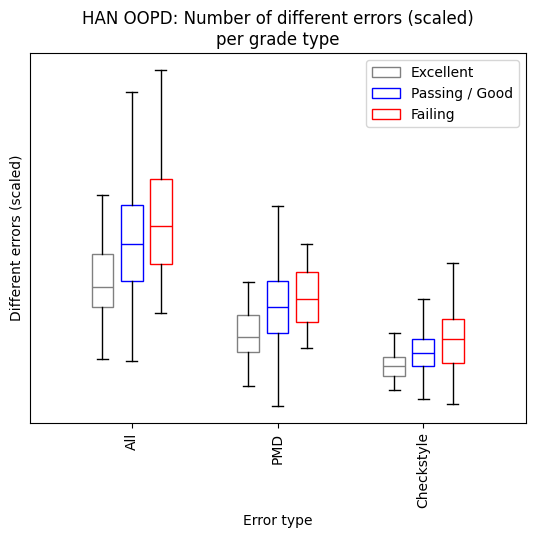

In [17]:
plot_boxes_grade_cats(abt_final, ['errors_count', 'pmd_count', 'checkstyle_count'],
           ['All', 'PMD', 'Checkstyle'],
           "HAN OOPD: Number of different errors (scaled)\nper grade type",
           'Error type',
           'Different errors (scaled)',
           hide_y = True
           )

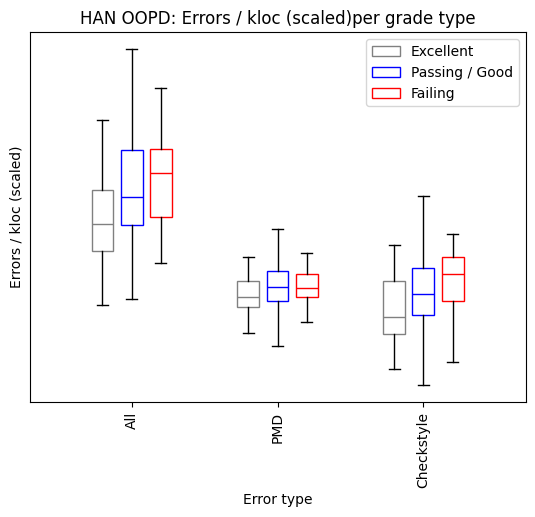

In [18]:
plot_boxes_grade_cats(abt_final, ['errors_total', 'pmd_total', 'checkstyle_total'],
           ['All', 'PMD', 'Checkstyle'],
           "HAN OOPD: Errors / kloc (scaled)per grade type",
           'Error type',
           'Errors / kloc (scaled)',
           hide_y = True
           )

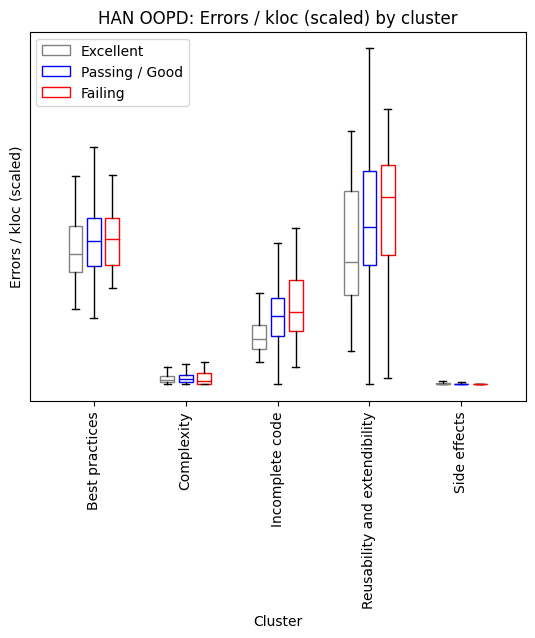

In [19]:
cluster_columns = [x for x in abt_final.columns if x.startswith("cluster_")]
labels = [x.replace('cluster_', '') for x in cluster_columns]


plot_boxes_grade_cats(abt_final,
           cluster_columns,
           labels,
           'HAN OOPD: Errors / kloc (scaled) by cluster',
           'Cluster',
           'Errors / kloc (scaled)',
           hide_y = True
           )

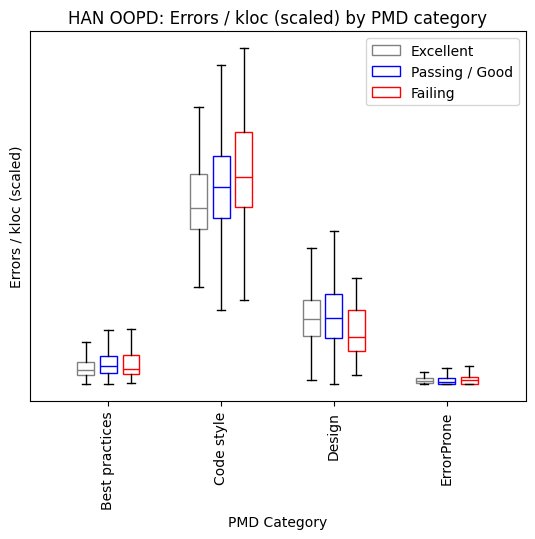

In [20]:
# Individual PMD categories
categories = [x for x in abt_final.columns if x.startswith('pmd_cat_')]
labels = [x.replace('pmd_cat_', '') for x in categories]

plot_boxes_grade_cats(abt_final,
    categories,
           labels,
           'HAN OOPD: Errors / kloc (scaled) by PMD category',
           'PMD Category',
           'Errors / kloc (scaled)',
           hide_y = True)

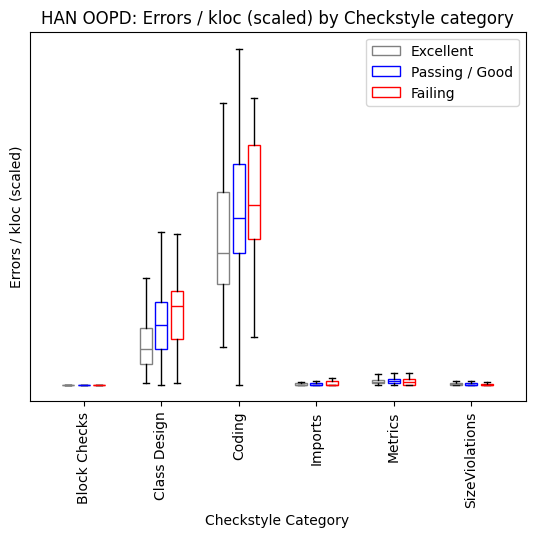

In [21]:
# Individual Checkstyle categories
categories = [x for x in abt_final.columns if x.startswith('checkstyle_cat_')]
labels = [x.replace('checkstyle_cat_', '') for x in categories]

plot_boxes_grade_cats(abt_final,
    categories,
           labels,
           'HAN OOPD: Errors / kloc (scaled) by Checkstyle category',
           'Checkstyle Category',
           'Errors / kloc (scaled)',
           hide_y = True)

/var/folders/zc/pfyjhy252g1fmlpp0765mxtm0000gn/T/ipykernel_62141/2941297884.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abt_cats.loc[:, ('Design')] = abt_cats['checkstyle_cat_Class Design'] + abt_cats['pmd_cat_Design']


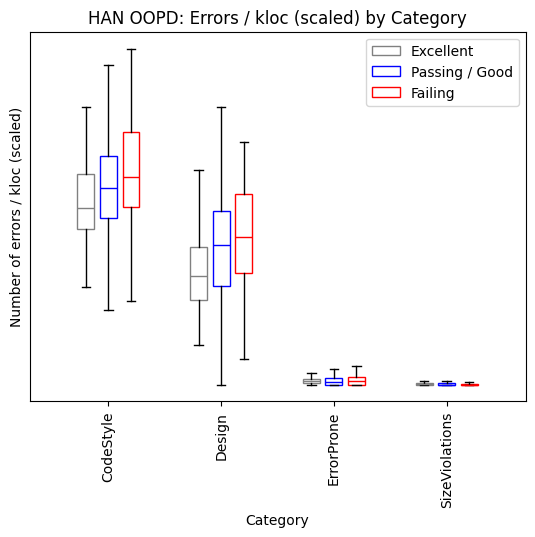

In [22]:
# Categories teachers were questioned on
# Individual PMD categories
abt_cats = abt_final[['grade', 
                      'checkstyle_cat_Class Design',
                      'checkstyle_cat_SizeViolations',
                      'pmd_cat_Design',
                      'pmd_cat_Code style',
                      'pmd_cat_ErrorProne',
                      ]]
abt_cats.loc[:, ('Design')] = abt_cats['checkstyle_cat_Class Design'] + abt_cats['pmd_cat_Design']
abt_cats = abt_cats.rename({
    'checkstyle_cat_SizeViolations': 'SizeViolations',
    'pmd_cat_Code style' : 'CodeStyle',
    'pmd_cat_ErrorProne' : 'ErrorProne'
}, axis = 1).drop(['checkstyle_cat_Class Design', 'pmd_cat_Design'], axis = 1)

categories = [x for x in abt_cats.columns if x != 'grade']
categories.sort()



plot_boxes_grade_cats(abt_cats,
    categories,
           categories,
           'HAN OOPD: Errors / kloc (scaled) by Category',
           'Category',
           'Number of errors / kloc (scaled)',
           hide_y = True)